In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.odr as odr
import matplotlib.ticker as mticker

# Orthogonal Distance Regression
### Or, how to fit your data

Many of you have already seen a situation where you have uncertainty in both your x-data and your y-data. The least squares method described in the textbook cannot account for both these uncertainties. There are different ways to generalize it, but we will focus on Orthogonal Distance Regression (ODR). Essentially, ODR tries to minimize the distance between your data and the model, weighted by uncertainties. The "orthogonal" part refers to the fact that it looks for the shortest distance between the model and your data, by taking a path orthogonal to the model line.

Ok, that's a lot of words. Let's see how to use it in practice.

## Mock up some data

For demonstration purposes, we'll create some fake data. This will be done by first establishing the "true" model for the data - in this case a linear line with a given slope and intercept. Next, we will make up some measurements, allowing ourselves to have heterogeneous uncertainties in both x- and y-directions.

For our little experiment here, it's important to decouple what values we would or would not know in the experiment. Anything labeled `true` would be unknown - we want to figure those out. I will use `meas` to represent the measured data.

In [2]:
# Define a linear function
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

In [3]:
# "True" values representing the phenomena we want to measure
true_slope = 3
true_inter = -4

# "True" x data values - these are made up
true_x = np.array([3, 5.5, 8.4, 12.3])
# True y is determined by the true model and the true x values
true_y = f([true_slope, true_inter], true_x)

# True standard deviations - these are made up
true_sx = np.array([.8, .5, .6, 1.0])
true_sy = np.array([2.8, 1.7, 2.5, 2.3])

<IPython.core.display.Javascript object>


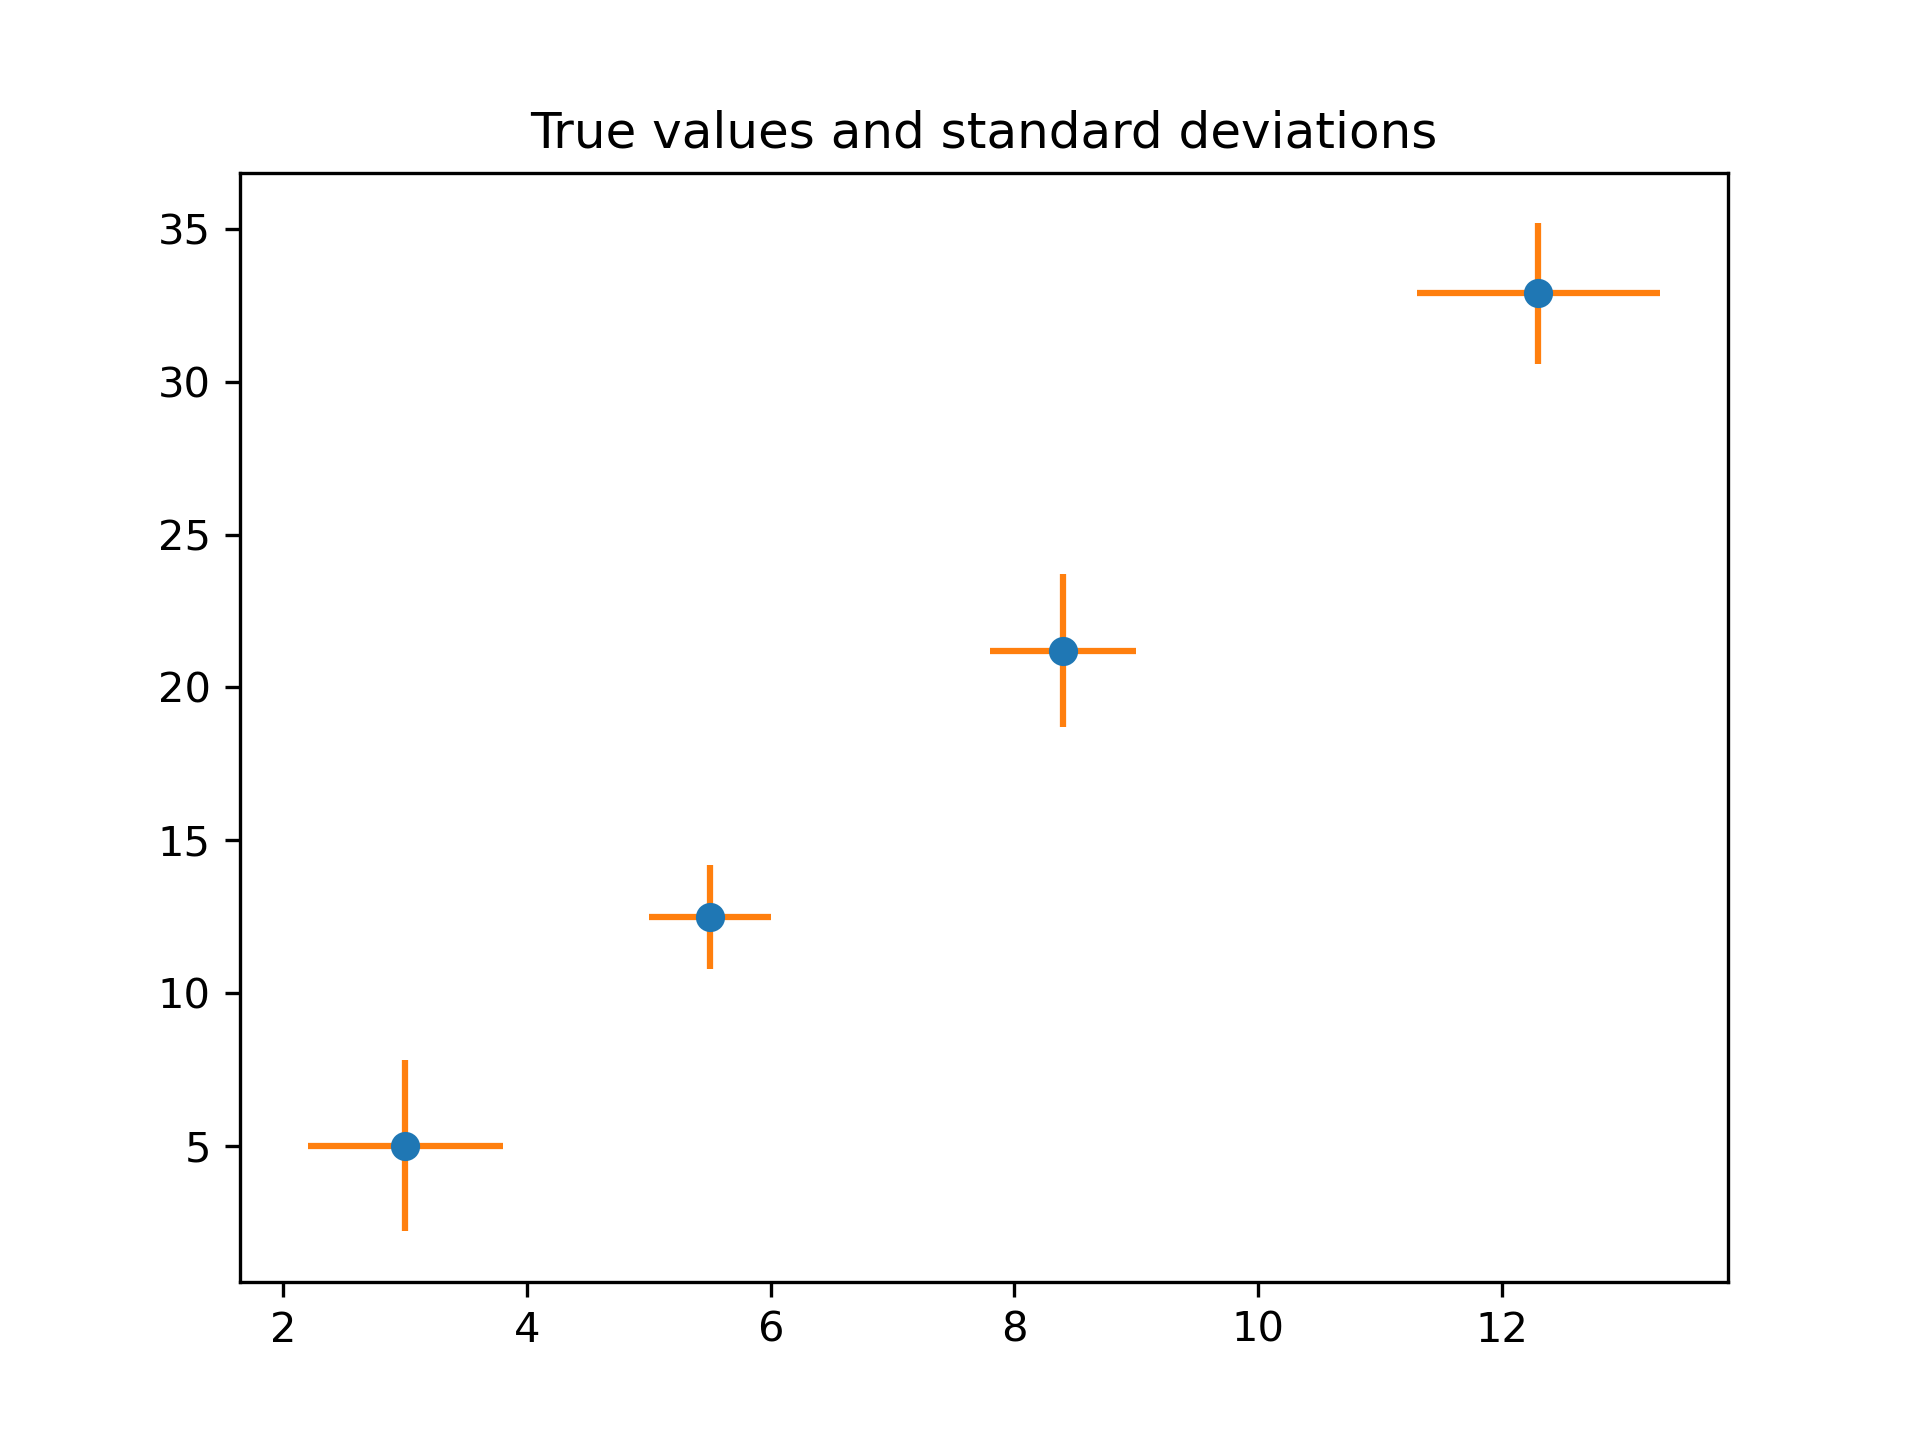

Text(0.5, 1.0, 'True values and standard deviations')

In [4]:
# Let's visualize the true data
plt.figure()
plt.plot(true_x, true_y, 'o')
plt.errorbar(true_x, true_y, xerr=true_sx, yerr=true_sy, ls='none')
plt.title('True values and standard deviations')

Now we "take the data." We will use the true values and standard deviations to simulate ten trials at each data point.

In [5]:
ntrials = 10
datax_meas = (true_x.reshape(-1, 1) +
              true_sx.reshape(-1, 1) * np.random.randn(len(true_x), ntrials))
datay_meas = (true_y.reshape(-1, 1) +
              true_sy.reshape(-1, 1) * np.random.randn(len(true_y), ntrials))

Plot the measured data. Colors correspond to repeated measurements of the same value.

<IPython.core.display.Javascript object>


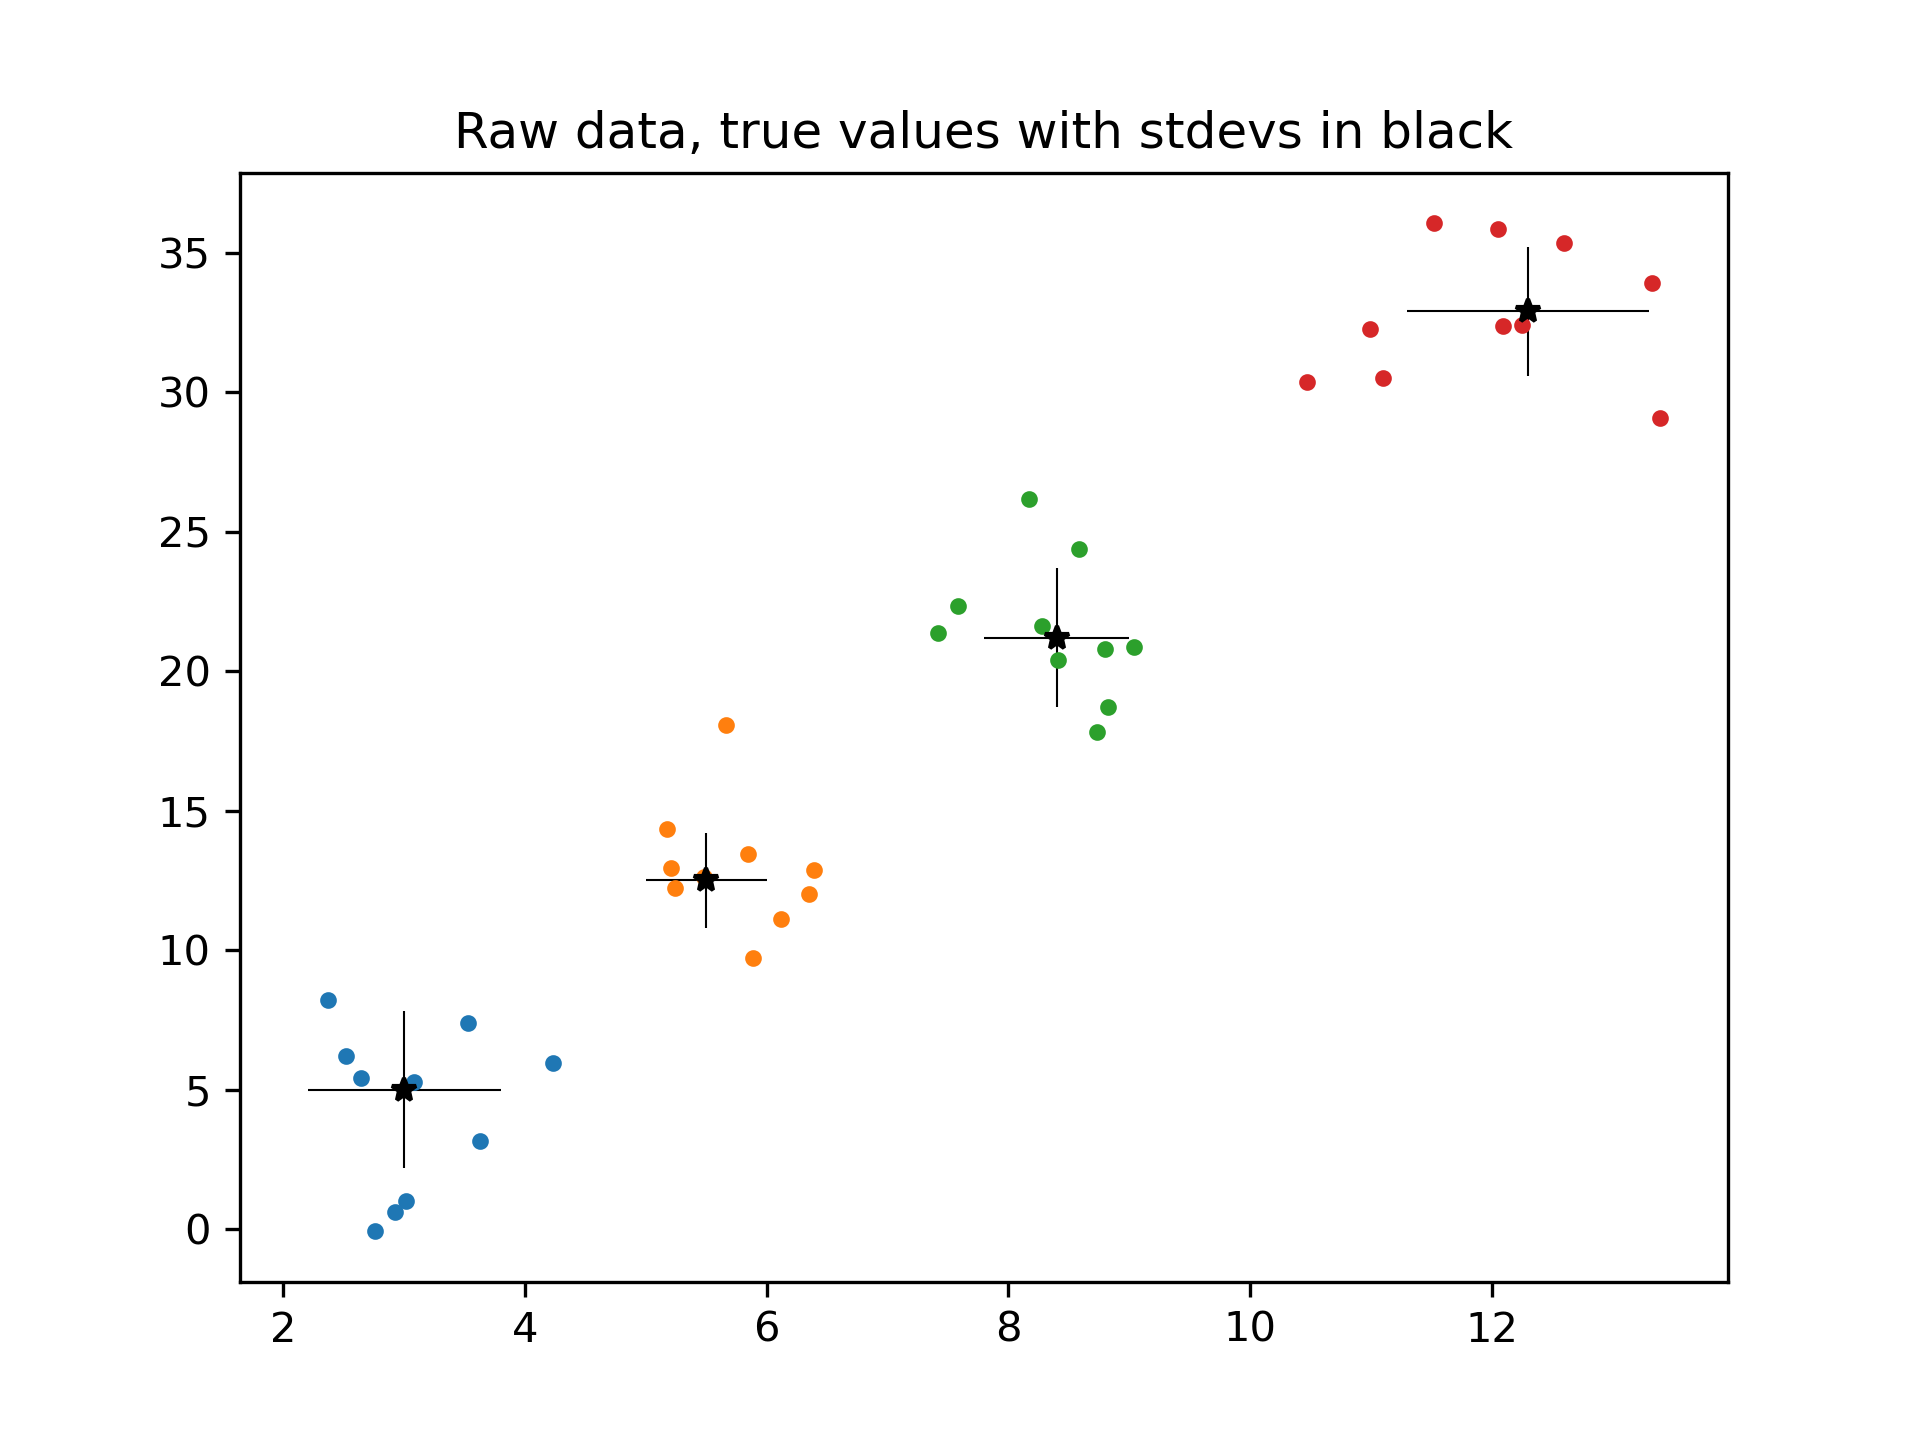

Text(0.5, 1.0, 'Raw data, true values with stdevs in black')

In [6]:
plt.figure()
for i in range(len(true_x)):
    plt.plot(datax_meas[i, :], datay_meas[i, :], '.')
plt.plot(true_x, true_y, 'k*')
plt.errorbar(true_x, true_y, xerr=true_sx, yerr=true_sy, ls='none', ecolor='k', elinewidth=.5)
plt.title('Raw data, true values with stdevs in black')

## Data Analysis

From here on out, we have our measured data, but we do not know the true values. We will compare to the true at the very end.

First we find the best estimate and uncertainty for each measurement. In other words, we combine all the blue, all the orange, etc in the plot above.

In [7]:
x_mean = np.mean(datax_meas, axis=1)
sx_meas = np.std(datax_meas, axis=1, ddof=1)
sx_mean = sx_meas / np.sqrt(ntrials)
y_mean = np.mean(datay_meas, axis=1)
sy_meas = np.std(datay_meas, axis=1, ddof=1)
sy_mean = sy_meas / np.sqrt(ntrials)

<IPython.core.display.Javascript object>


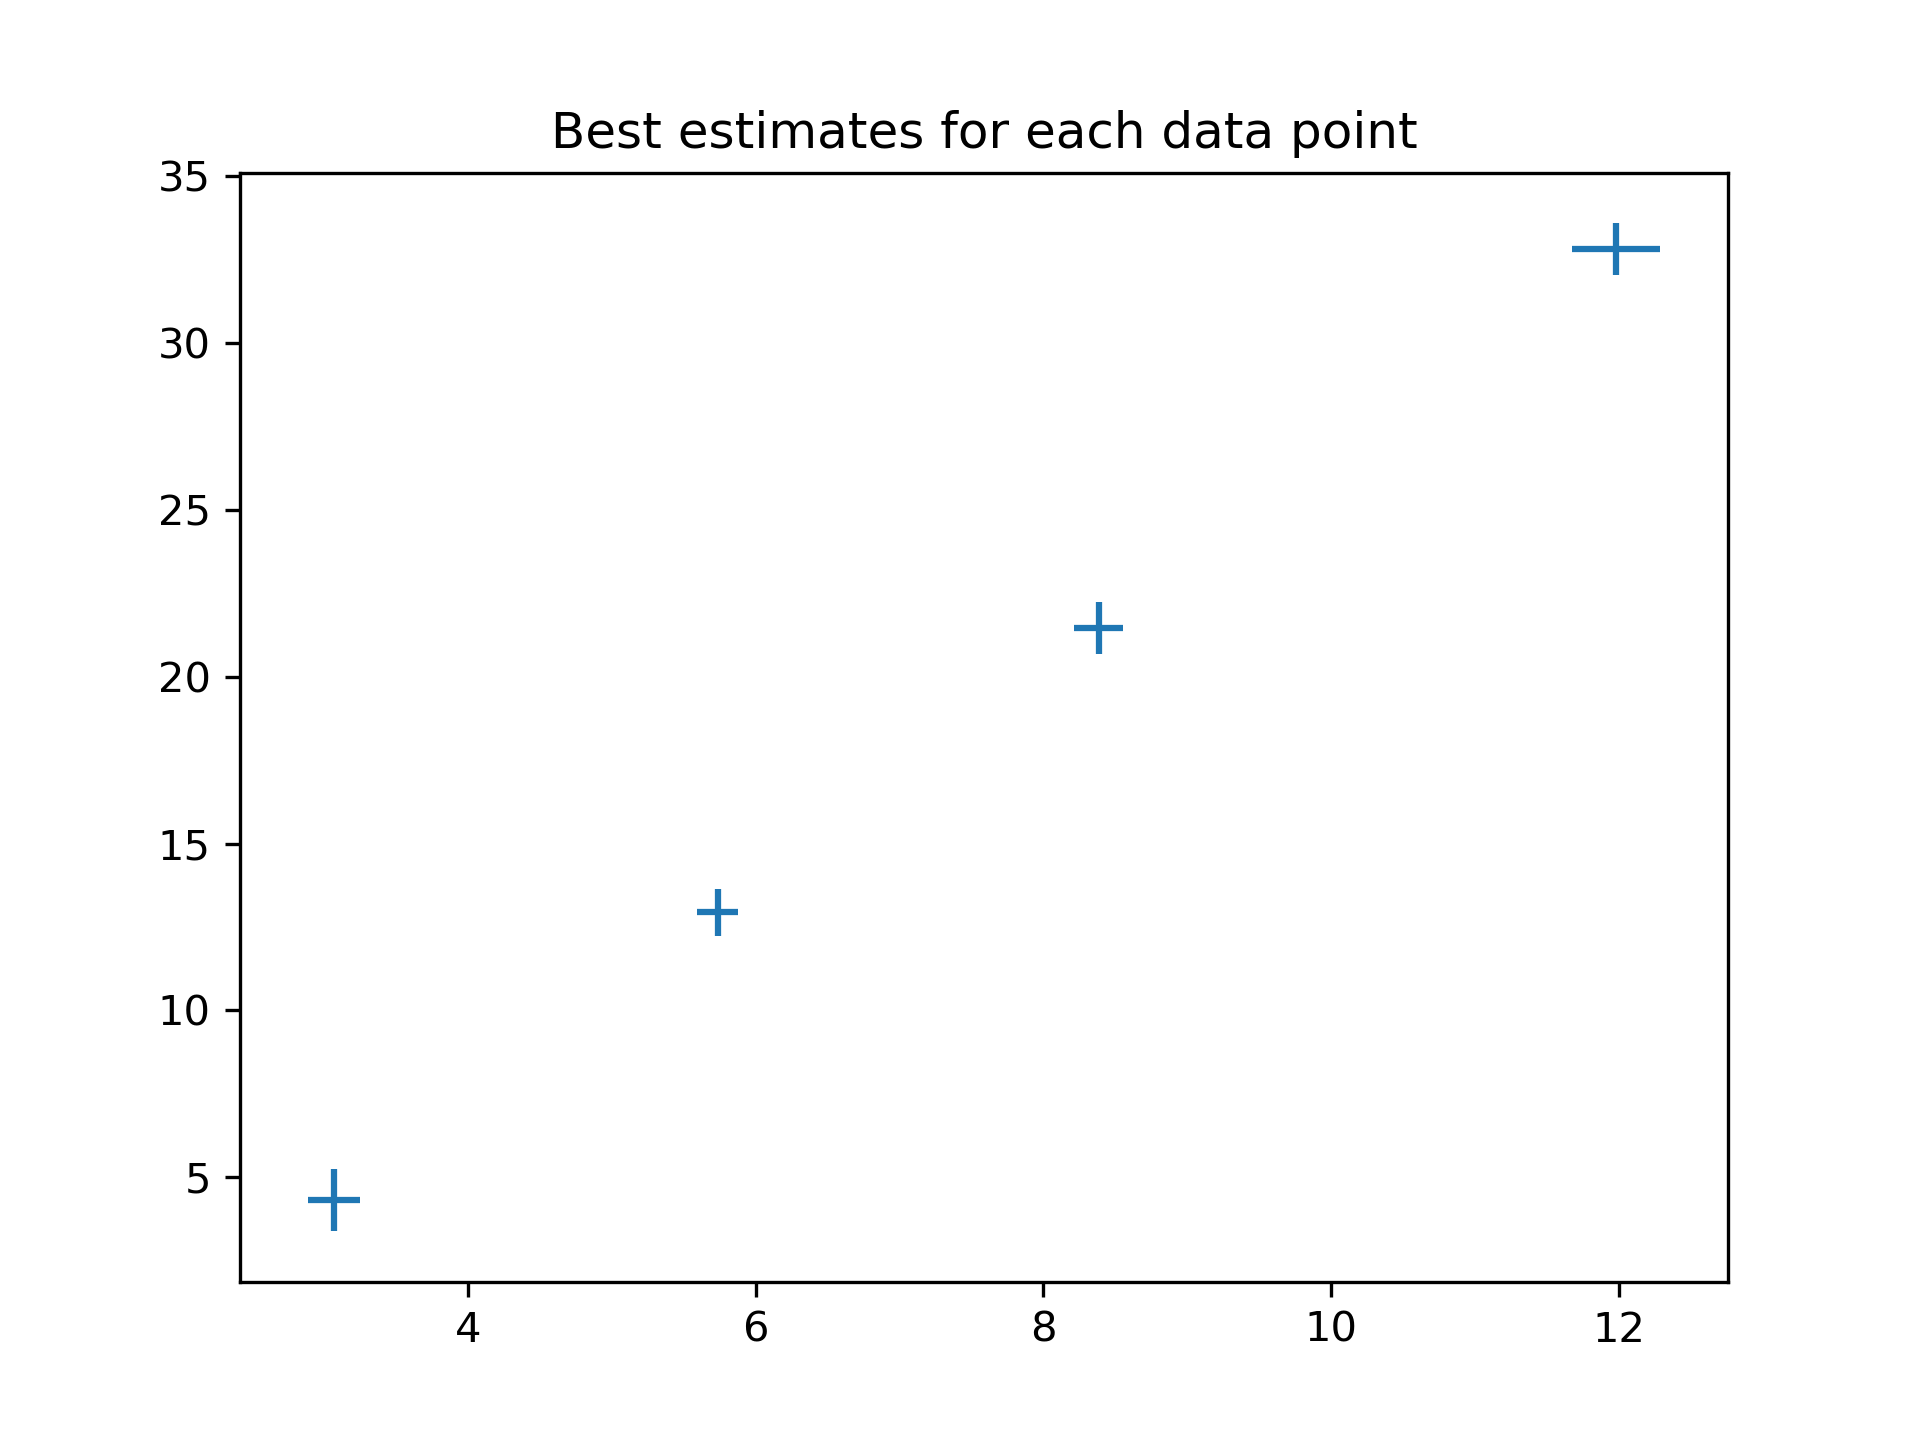

Text(0.5, 1.0, 'Best estimates for each data point')

In [8]:
plt.figure()
plt.errorbar(x_mean, y_mean, xerr=sx_mean, yerr=sy_mean, ls='none')
plt.title('Best estimates for each data point')

Here's where we need to fit the data to a line. We will use ODR, following the example here: https://docs.scipy.org/doc/scipy/reference/odr.html

In [9]:
linear = odr.Model(f)
mydata = odr.RealData(x_mean, y_mean, sx=sx_mean, sy=sy_mean)
myodr = odr.ODR(mydata, linear, beta0=[0, 0])
myoutput = myodr.run()

`pprint()` will print out all the results all pretty-like.
We can see the Beta values (fits to the model, this is the slope and intercept), the standard error on beta, and some other statistics on the fit. We don't need to copy-paste this into our code though. `myoutput` contains attributes with these values we can use, as in the plot below.

In [10]:
myoutput.pprint()

Beta: [ 3.20130706 -5.45266627]
Beta Std Error: [0.01339186 0.10025321]
Beta Covariance: [[ 0.03030588 -0.20953842]
 [-0.20953842  1.69840686]]
Residual Variance: 0.005917726164436238
Inverse Condition #: 0.04756725658759075
Reason(s) for Halting:
  Sum of squares convergence


## Compare with true values
Now we unmask the true values and compare with our results

<IPython.core.display.Javascript object>


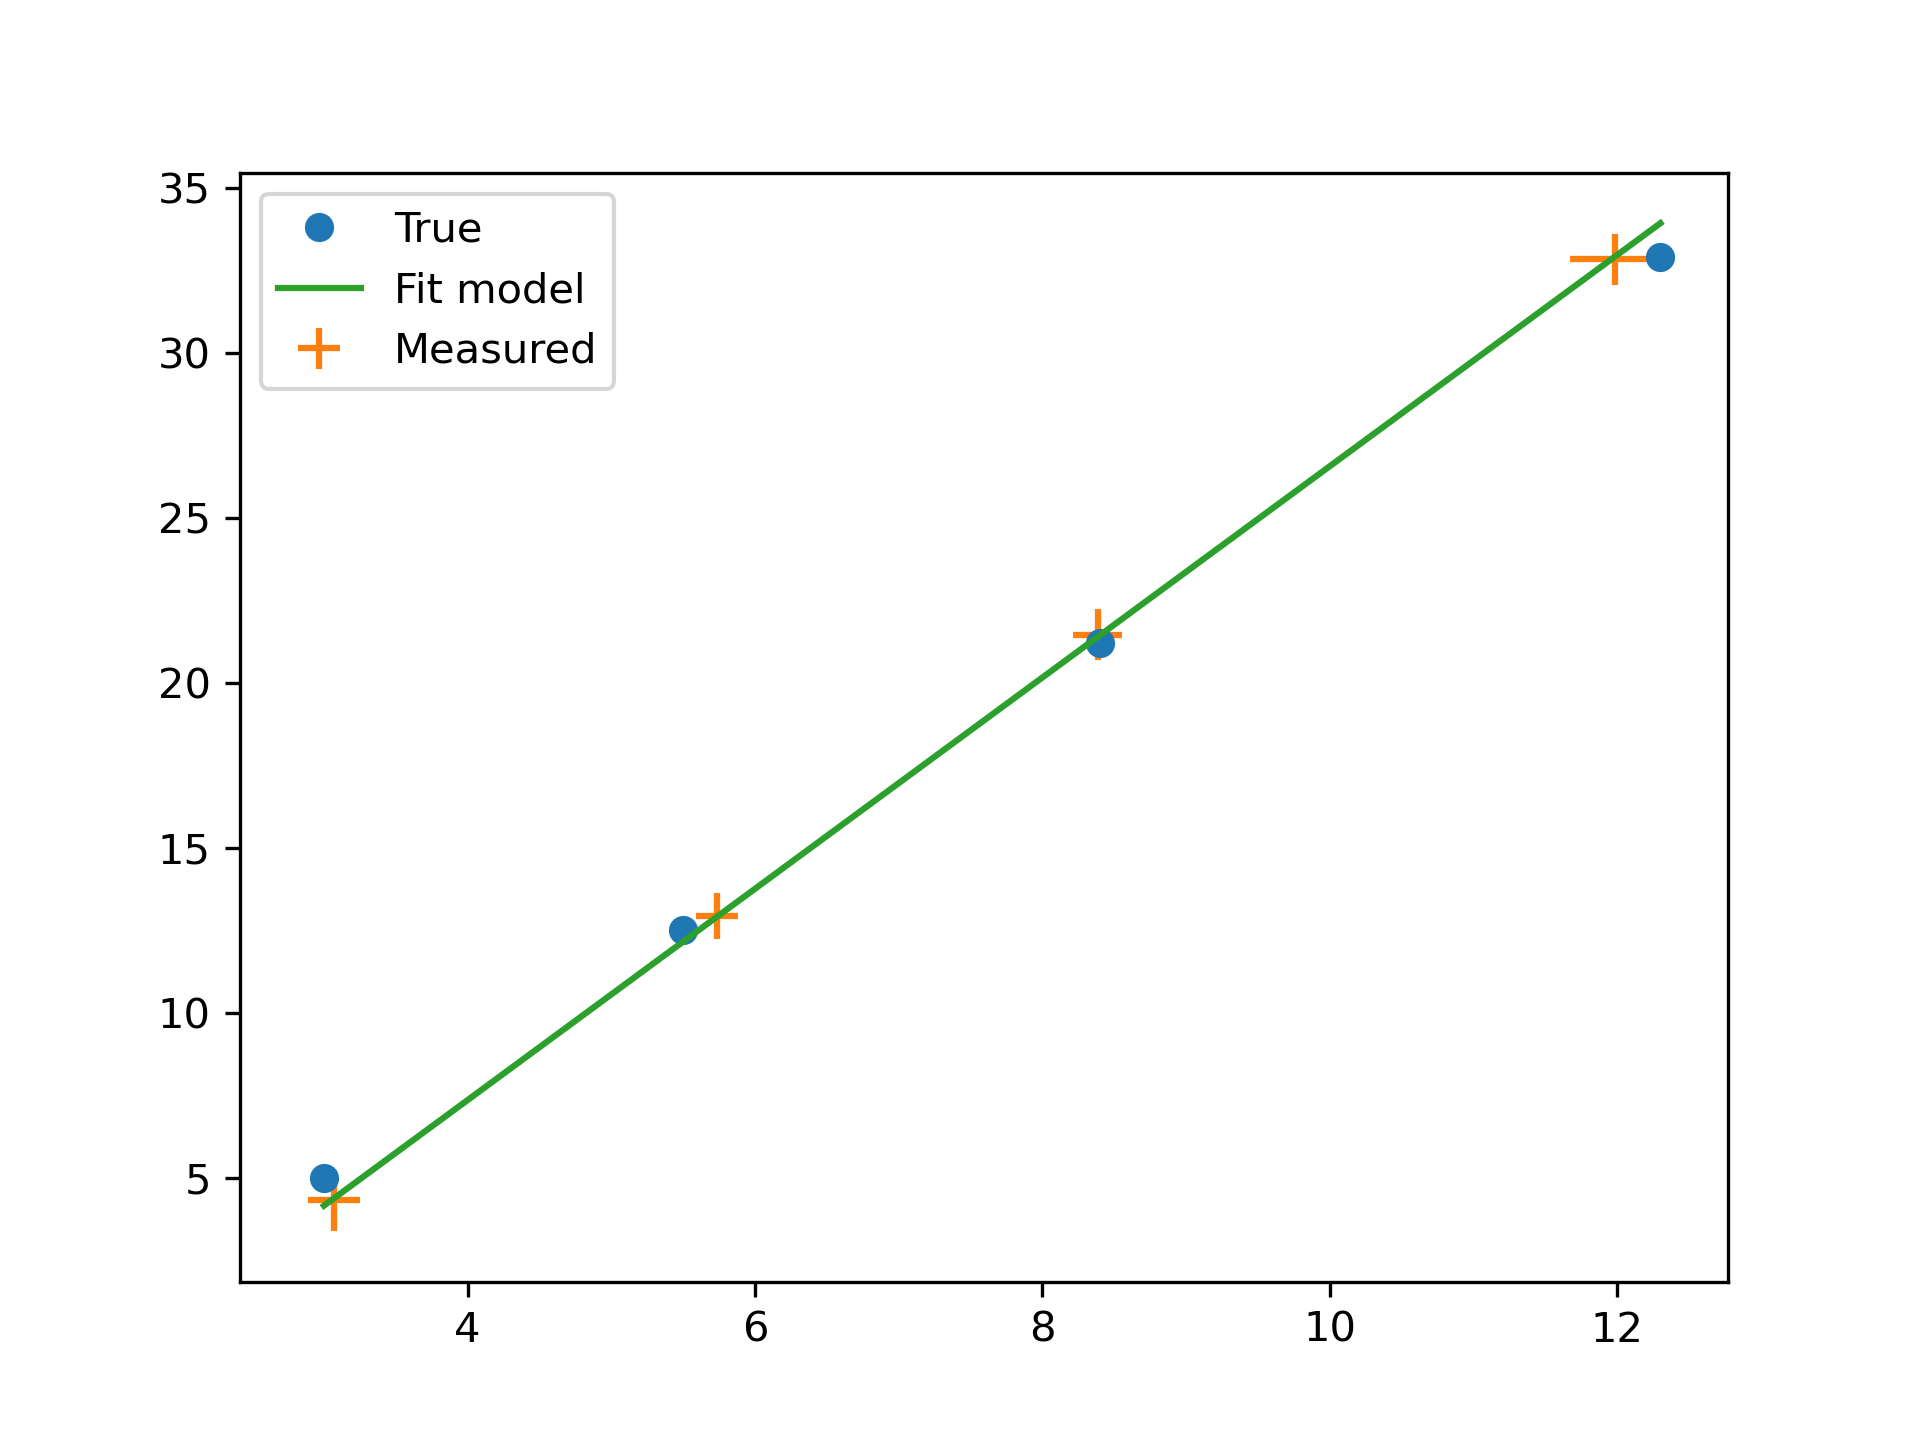

In [11]:
plt.figure()
plt.plot(true_x, true_y, 'o', label='True')
plt.errorbar(x_mean, y_mean, xerr=sx_mean, yerr=sy_mean, ls='none', label='Measured')
plt.plot(true_x, f(myoutput.beta, true_x), label='Fit model')
plt.legend()

In [12]:
# Discrepancy on the slope and intercept
slope_z = np.abs(true_slope - myoutput.beta[0]) / np.sqrt(myoutput.cov_beta[0, 0])
inter_z = np.abs(true_inter - myoutput.beta[1]) / np.sqrt(myoutput.cov_beta[1, 1])
print(f'Slope and intercept are within {slope_z:.2f} and {inter_z:.2f} sigma, respectively.')

Slope and intercept are within 1.16 and 1.11 sigma, respectively.


Hold on, when I look at the full printout, there are two options for my error bars: Standard Error and Covariance. In theory the square root of the diagonal of the covariance matrix should equal the standard error. But I can easily check, and find out that's not the case. A little internet sleuthing led me to an [explanation](https://stackoverflow.com/questions/41028846/how-to-compute-standard-error-from-odr-results) that says one of these is scaled by the residual variance and one is not. Unfortunately that post isn't super clear on which is the right one to use. 

So let's do an experiment! 

I'm going to repeat my above experiment 10,000 times and look at the statistics.

In [13]:
nexp = 10000
slope_zs = np.zeros((nexp, 2))
inter_zs = np.zeros((nexp, 2))

for i in range(nexp):
    datax_meas = (true_x.reshape(-1, 1) +
                  true_sx.reshape(-1, 1) * np.random.randn(len(true_x), ntrials))
    datay_meas = (true_y.reshape(-1, 1) +
                  true_sy.reshape(-1, 1) * np.random.randn(len(true_y), ntrials))

    x_mean = np.mean(datax_meas, axis=1)
    sx_meas = np.std(datax_meas, axis=1, ddof=1)
    sx_mean = sx_meas / np.sqrt(ntrials)
    y_mean = np.mean(datay_meas, axis=1)
    sy_meas = np.std(datay_meas, axis=1, ddof=1)
    sy_mean = sy_meas / np.sqrt(ntrials)

    mydata = odr.RealData(x_mean, y_mean, sx=sx_mean, sy=sy_mean)
    myodr = odr.ODR(mydata, linear, beta0=[0, 0])
    myoutput = myodr.run()

    slope_zs[i, 0] = np.abs(true_slope - myoutput.beta[0]) / myoutput.sd_beta[0]
    inter_zs[i, 0] = np.abs(true_inter - myoutput.beta[1]) / myoutput.sd_beta[1]
    slope_zs[i, 1] = np.abs(true_slope - myoutput.beta[0]) / np.sqrt(myoutput.cov_beta[0, 0])
    inter_zs[i, 1] = np.abs(true_inter - myoutput.beta[1]) / np.sqrt(myoutput.cov_beta[1, 1])


<IPython.core.display.Javascript object>


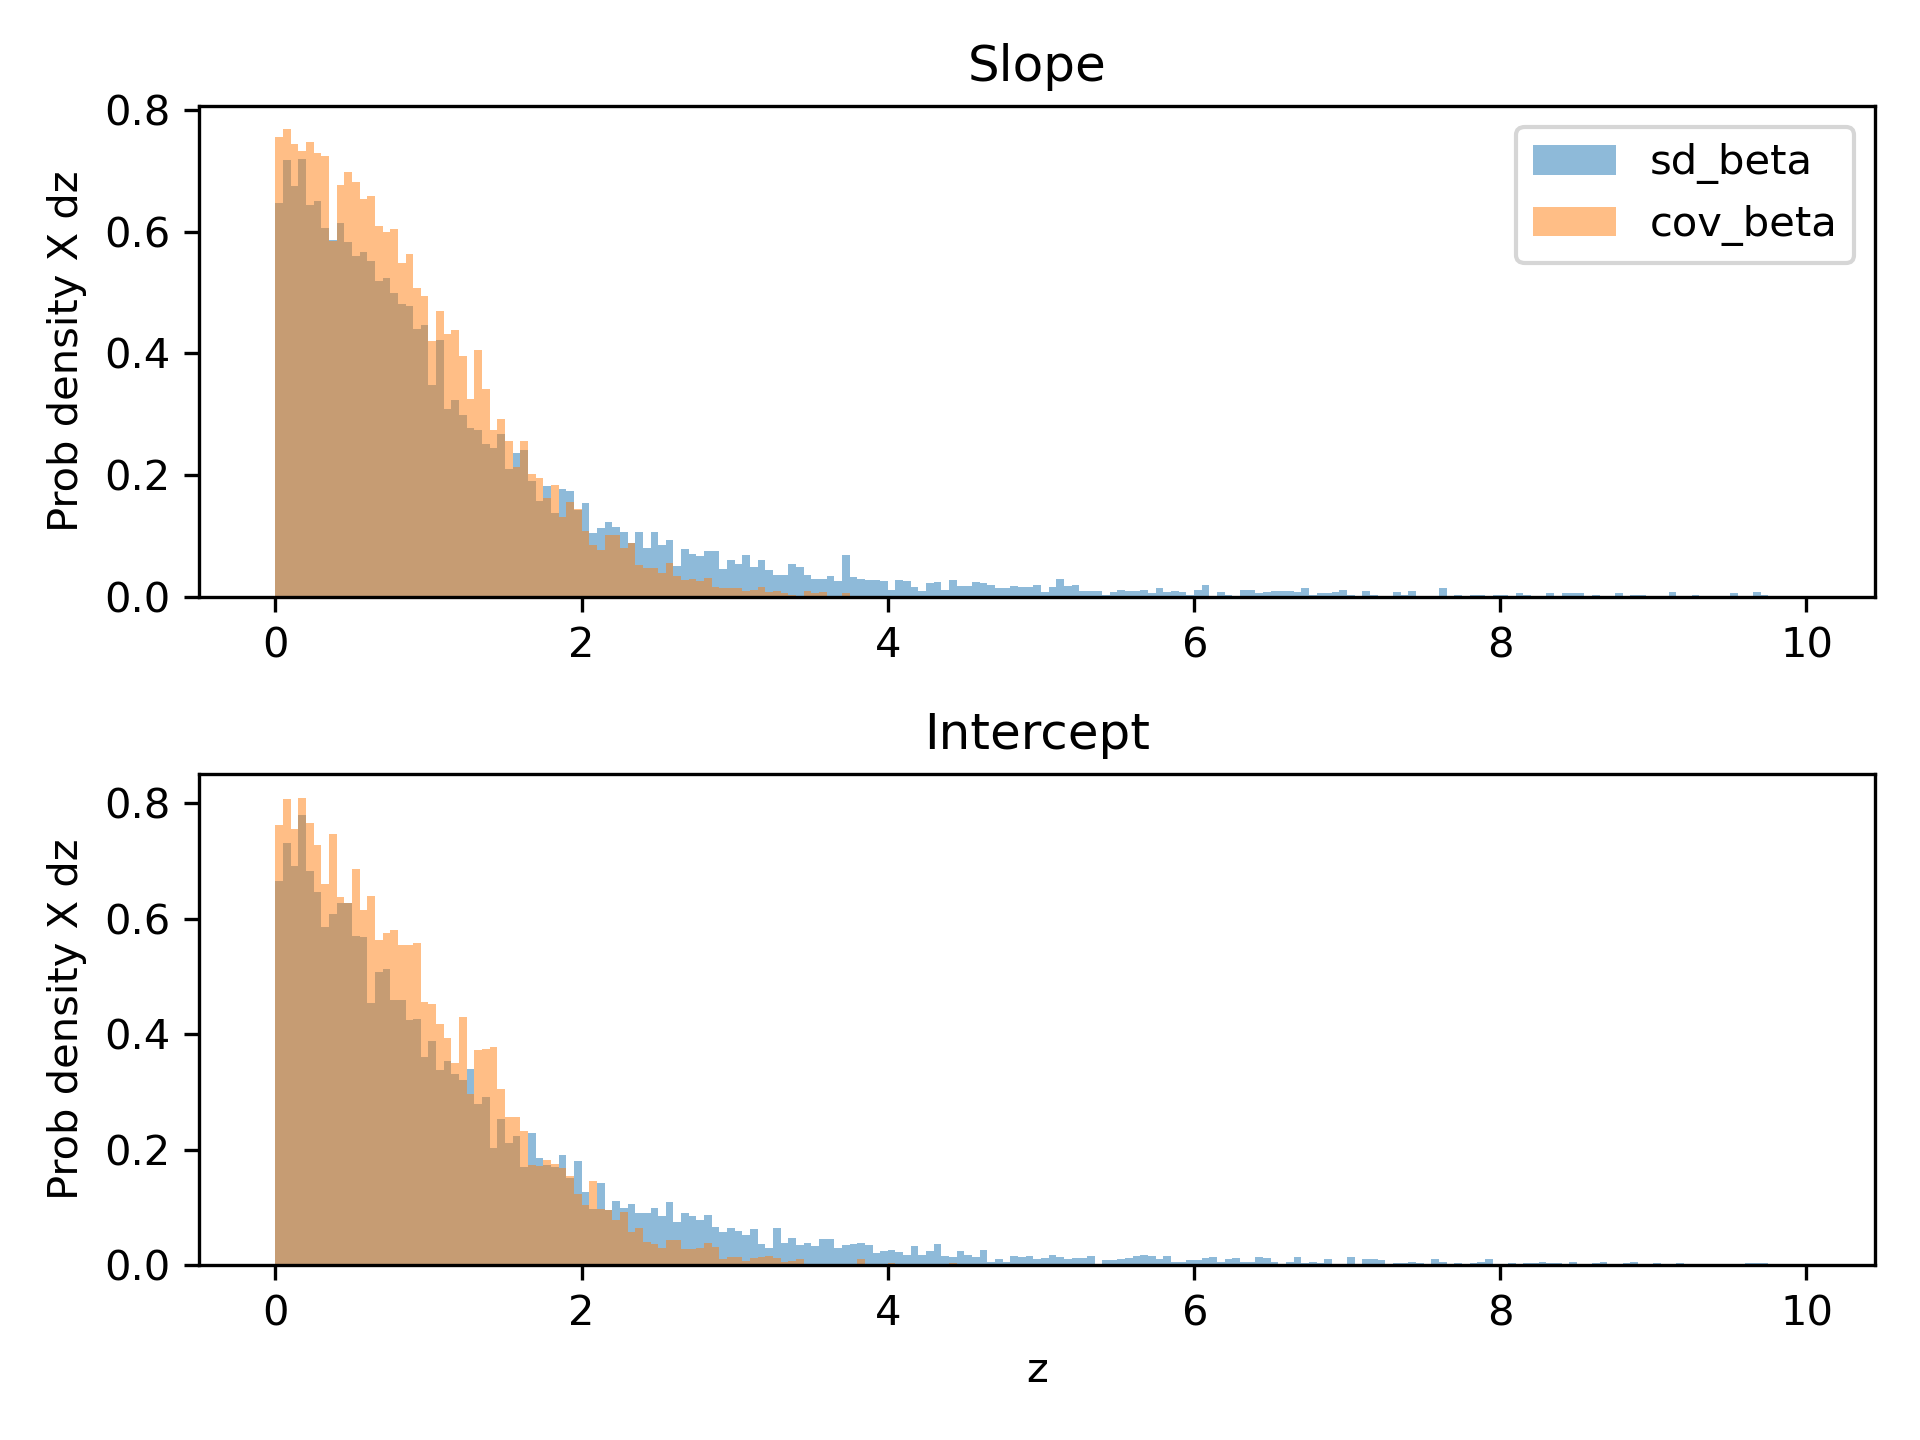

In [14]:
plt.figure()
dz = .05
bins = np.arange(0, 10, dz)
ax = plt.subplot(2,1,1)
hist_sd_slope, _, _ = plt.hist(slope_zs[:, 0], bins=bins, label='sd_beta', density=True, alpha=.5)
hist_cov_slope, _, _ = plt.hist(slope_zs[:, 1], bins=bins, label='cov_beta', density=True, alpha=.5)
plt.legend()
plt.title('Slope')
plt.ylabel('Prob density X dz')
plt.subplot(2,1,2, sharex=ax)
hist_sd_inter, _, _ = plt.hist(inter_zs[:, 0], bins=bins, label='b sd_beta', density=True, alpha=.5)
hist_cov_inter, _, _ = plt.hist(inter_zs[:, 1], bins=bins, label='b cov_beta', density=True, alpha=.5)
plt.title('Intercept')
plt.xlabel('z')
plt.ylabel('Prob density X dz')
plt.tight_layout()

Now let's look at the probability of getting $z$ or larger. This should give us a result similar to Table A in Taylor.

In [15]:
smaller_prob_slope = np.zeros((len(bins), 2))
smaller_prob_inter = np.zeros((len(bins), 2))
for i in range(len(bins)-1):
    smaller_prob_slope[i + 1, 0] = np.sum(hist_sd_slope[:i + 1]) * dz
    smaller_prob_slope[i + 1, 1] = np.sum(hist_cov_slope[:i + 1]) * dz
    smaller_prob_inter[i + 1, 0] = np.sum(hist_sd_inter[:i + 1]) * dz
    smaller_prob_inter[i + 1, 1] = np.sum(hist_cov_inter[:i + 1]) * dz

<IPython.core.display.Javascript object>


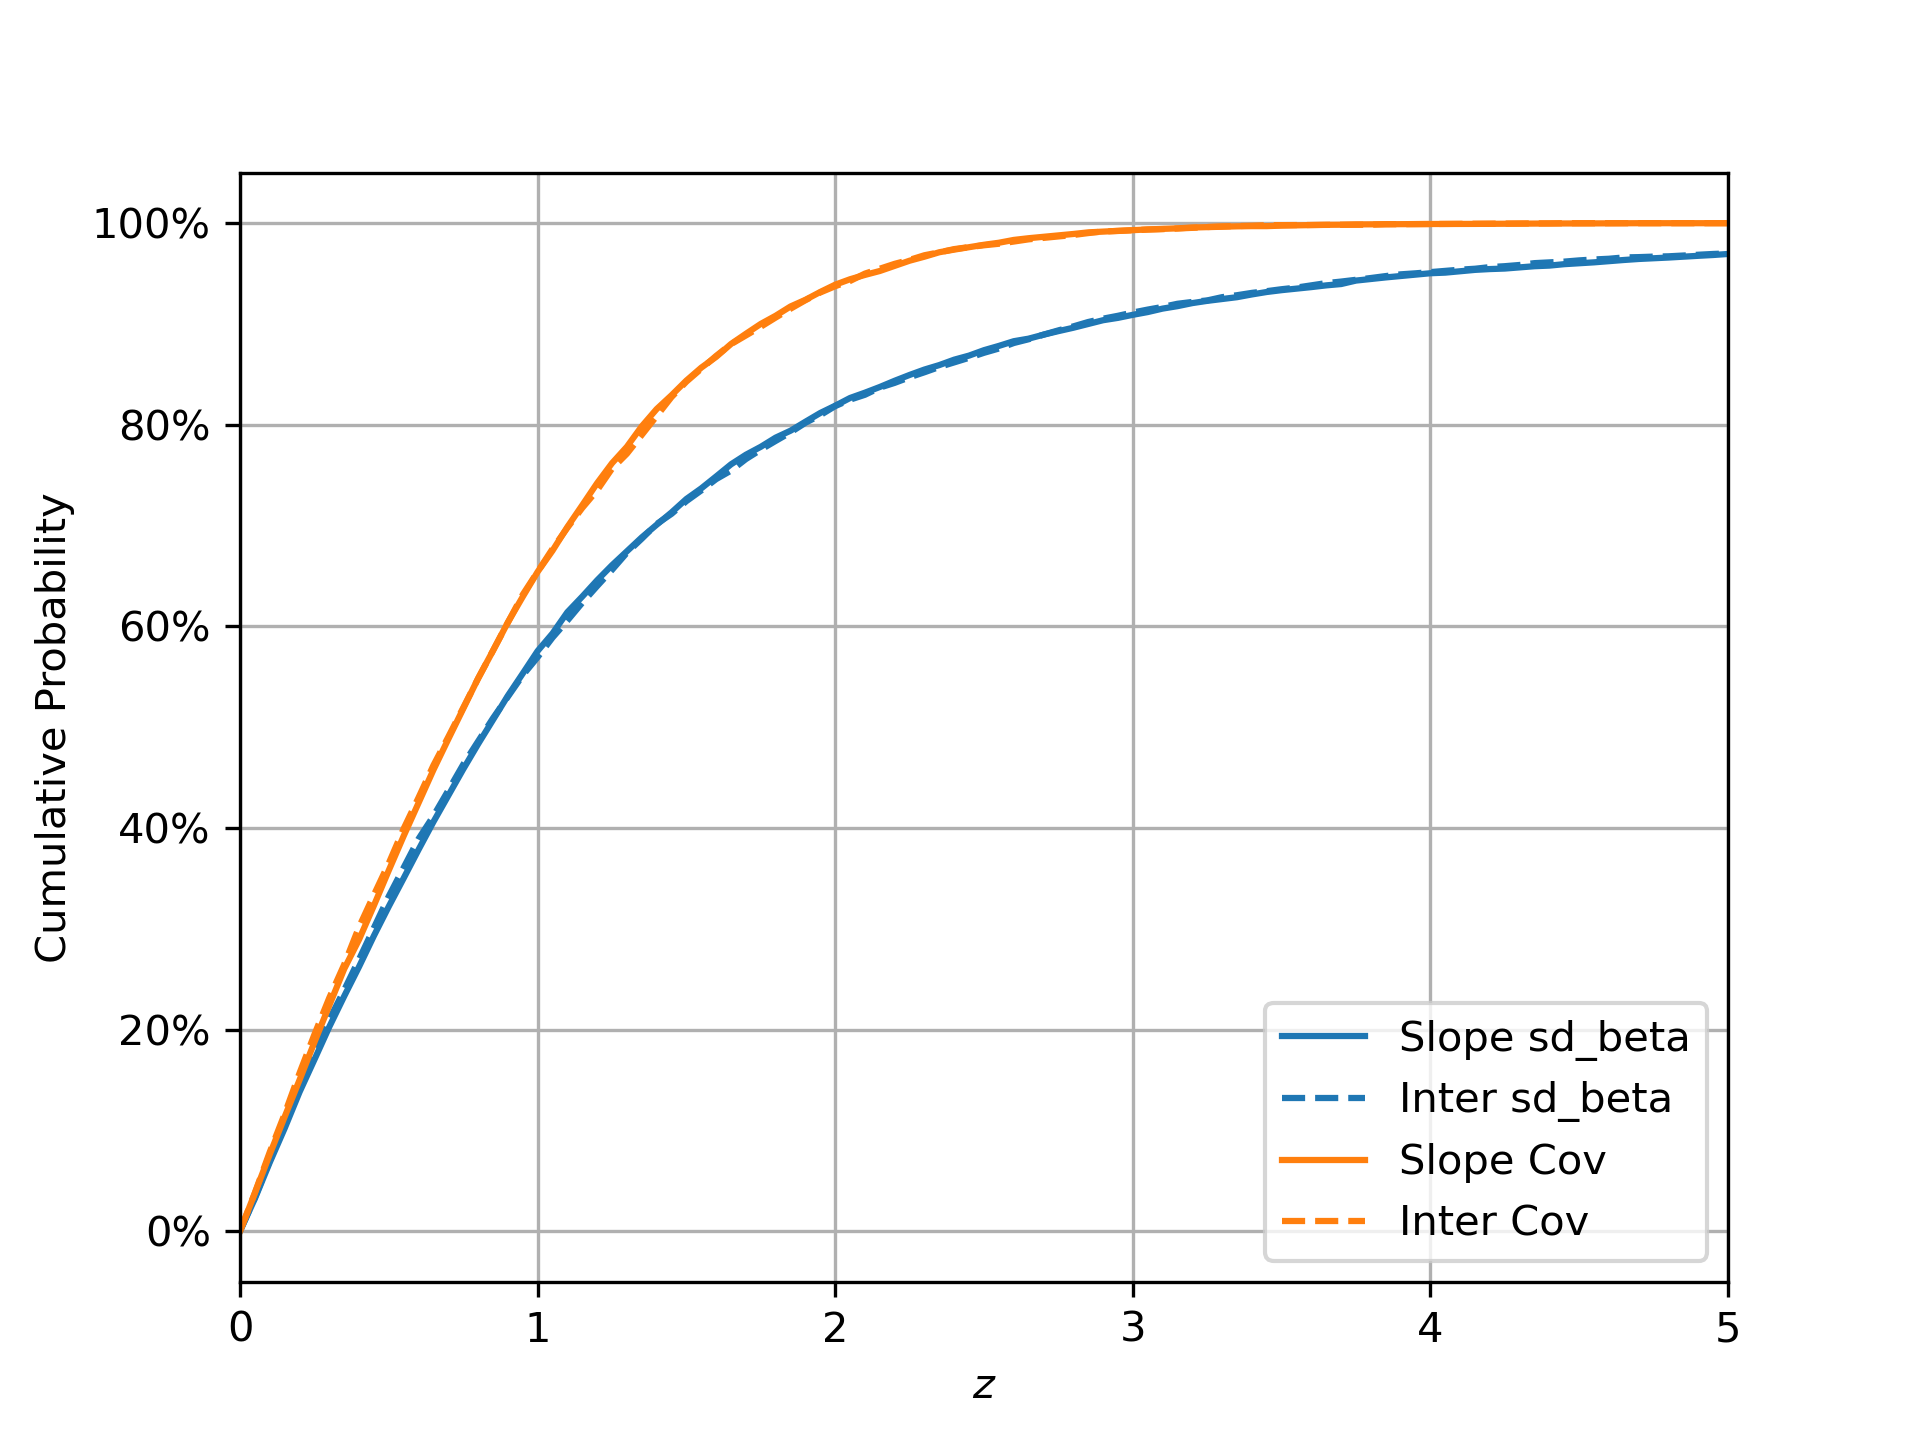

In [16]:
plt.figure()
plt.plot(bins, smaller_prob_slope[:, 0], 'C0', label='Slope sd_beta')
plt.plot(bins, smaller_prob_inter[:, 0], '--C0', label='Inter sd_beta')
plt.plot(bins, smaller_prob_slope[:, 1], 'C1', label='Slope Cov')
plt.plot(bins, smaller_prob_inter[:, 1], '--C1', label='Inter Cov')
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
plt.xlabel('$z$')
plt.ylabel('Cumulative Probability')
plt.xlim([0, 5])
plt.grid()
plt.legend()

Doing a quick spot check, the orange line (using `cov_beta`) is much closer to the expected behavior (Table A in Taylor). Although it is a bit lower than expected, so more thinking is needed to figure out why.

# More Shenanigans...
## Is the Residual Variance Correct?

**TL;DR: Yes, it's correct. BUT it seems the default is to allow data to move around if uncertainties are not given. E.g. if you don't give it x-uncertainties, it will move x-values around! If you do not want x values to move, you should use the `ifixx` keyword in the ODR class.**

I had a Phys 221 student point out that when she tried to fit some data that was clearly not linear, ODR happily fit it and reported a very small residual variance. Our understanding was that the residual variance should be something like the reduced $\chi^2$, which should be very large for a bad fit. I'm going to investigate that further here.

In [17]:
# Student's Data
# (I think this example is actually from the prelab)

extension = np.array([1, 2, 3, 4, 5, 6])
force = np.array([33.16, 43.5, 87.52, 123.14, 138.18, 122.66])
force_err = np.array([.5, .5, .5, .5, .5, .5])

In [18]:
student_model = odr.Model(f)
student_data = odr.RealData(extension, force, sy=force_err)
student_odr = odr.ODR(student_data, student_model, beta0=[0, 0])
student_output = student_odr.run()

In [19]:
student_output.pprint()

Beta: [25.74075864  1.26742316]
Beta Std Error: [ 5.37512834 20.63229423]
Beta Covariance: [[  44.47641952 -155.6675837 ]
 [-155.6675837   655.31059022]]
Residual Variance: 0.6496027553277961
Inverse Condition #: 0.09320859834333298
Reason(s) for Halting:
  Sum of squares convergence


In [20]:
def chiSquared(measured, err_measured, model):
    chiSquared = np.sum((measured - model)**2 / err_measured**2)
    return chiSquared

<IPython.core.display.Javascript object>


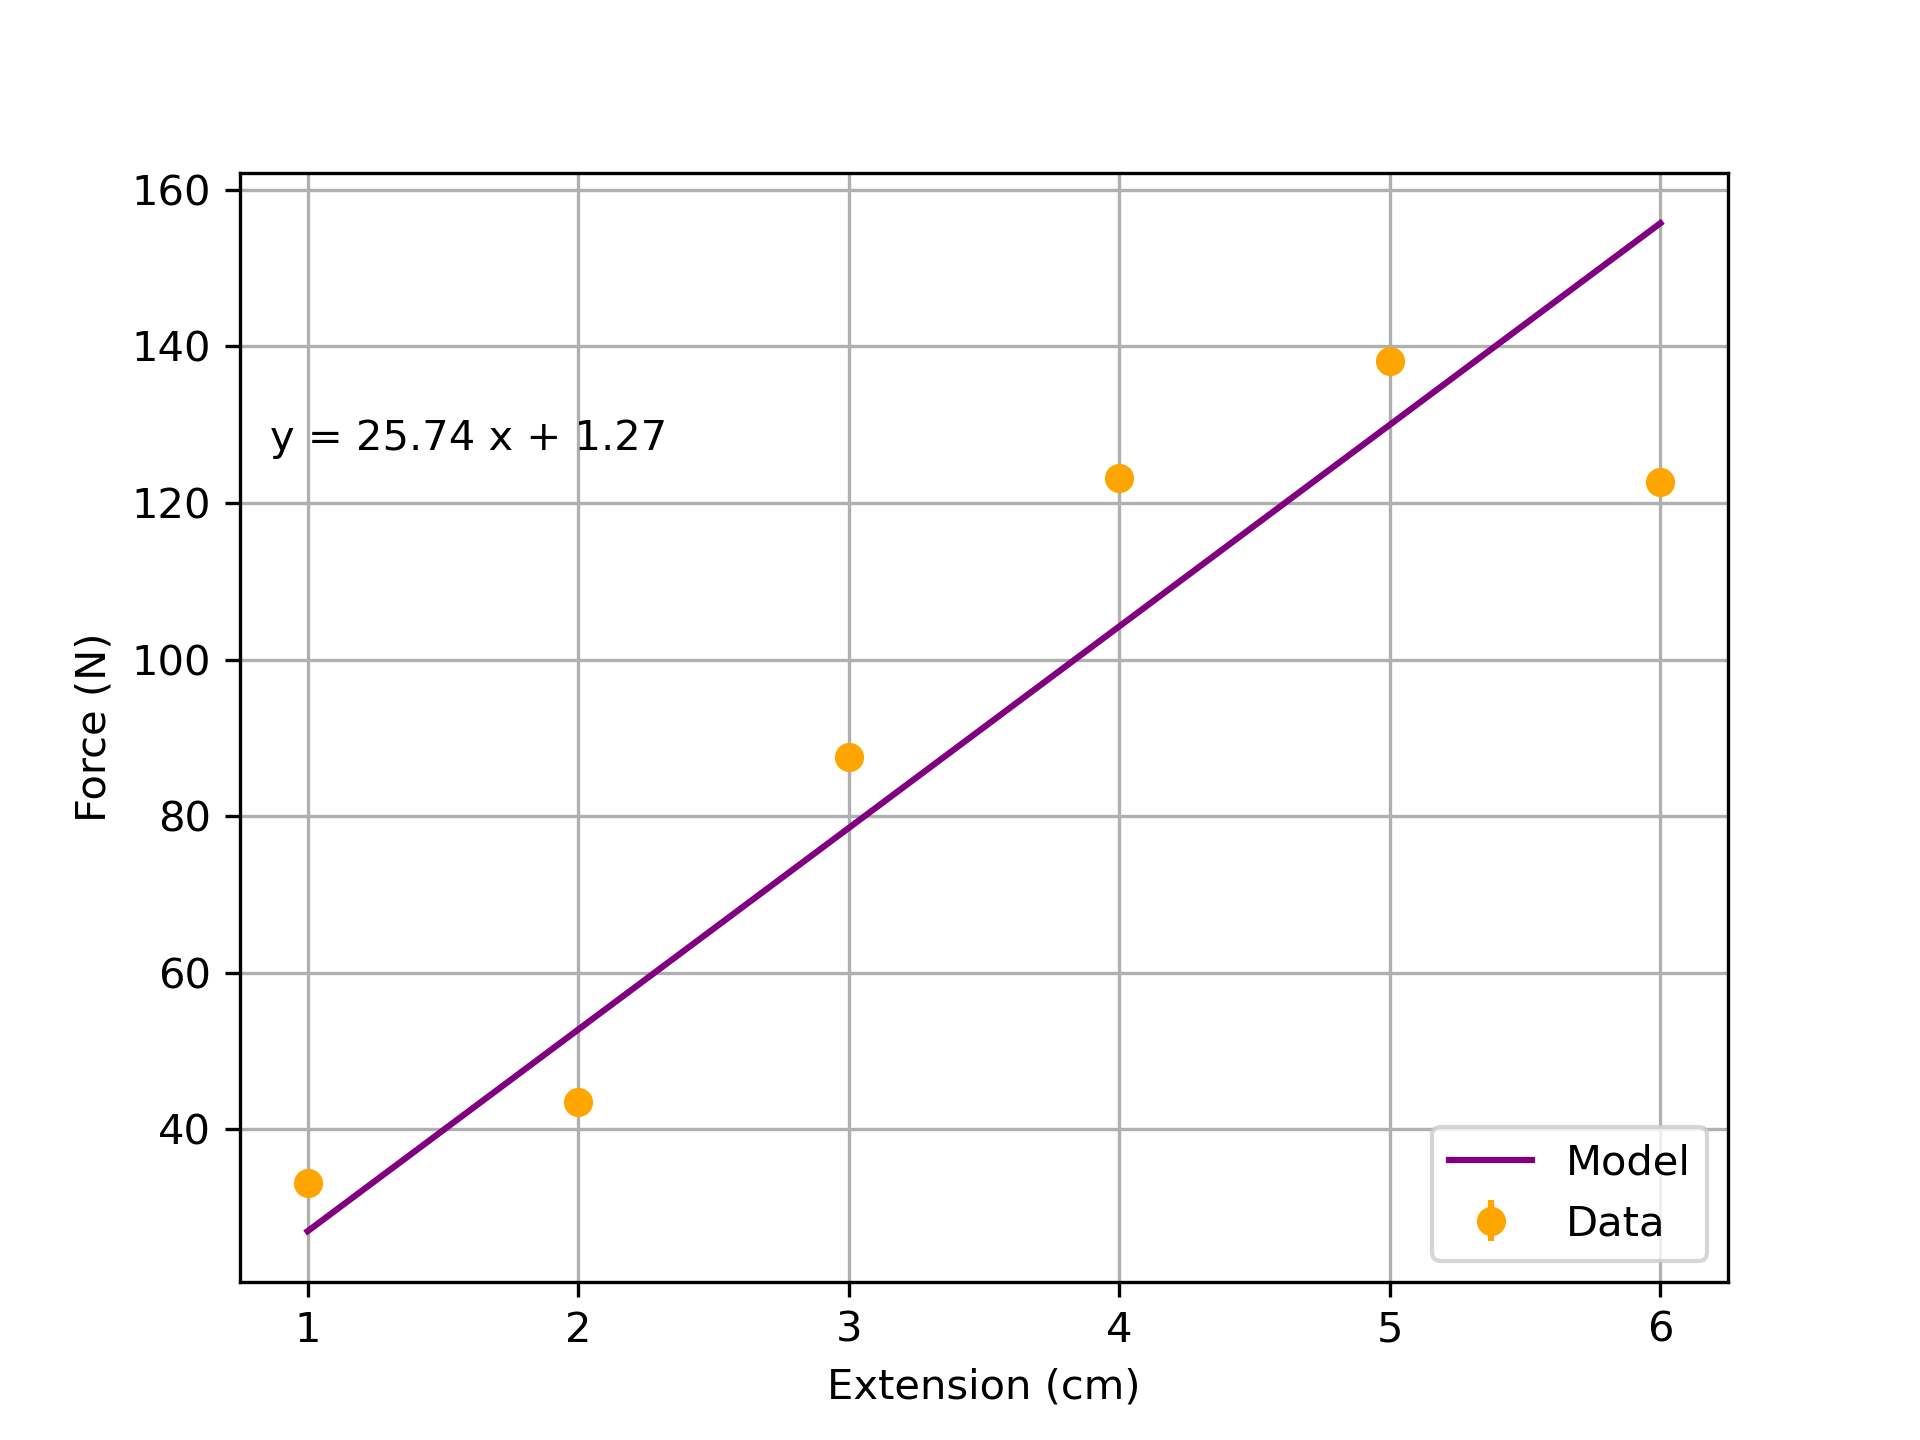

1722.3220708076801


In [21]:
m = student_output.beta[0]
b = student_output.beta[1]

plt.figure()
model = f((m, b), extension)
chiSquared_fit = chiSquared(force, force_err, model)

plt.errorbar(extension, force, yerr=force_err, marker="o",
             linestyle="None",label="Data",color="orange")
plt.plot(extension, model, linestyle='-',color="purple",
        label="Model")

plt.annotate("y = %.2f x + %.2f" %(m, b), xy=(.02, .75),
            xycoords='axes fraction')

plt.xlabel("Extension (cm)")
plt.ylabel("Force (N)")
plt.grid()
plt.legend(loc='lower right')

print(chiSquared_fit / (6 - 2))

So the reported residual variance was 0.649, but my calculated reduced $\chi^2=1722$. Clearly something is off...

I dug a bit into the original [ODRPack guide](https://docs.scipy.org/doc/external/odrpack_guide.pdf), and found that ODR allows $x$ and $y$ to move around, which makes sense. Except that I would not expect it to move $x$ around when no uncertainty is given. If I look at the output object, I can see what it decided the final values were. The `delta`s are the $x$ shifts, and `eps` are the $y$ shifts.

In [22]:
print(student_output.delta)
print(student_output.eps)

[ 0.23890119 -0.35917559  0.35068488  0.73433772  0.31878188 -1.28354835]
[-0.00232035  0.00348831 -0.00340605 -0.00713233 -0.00309619  0.01246669]


Interesting! It looks like it freely allowed $x$ to move around! Let's try plotting what it found as the best fit...

<IPython.core.display.Javascript object>


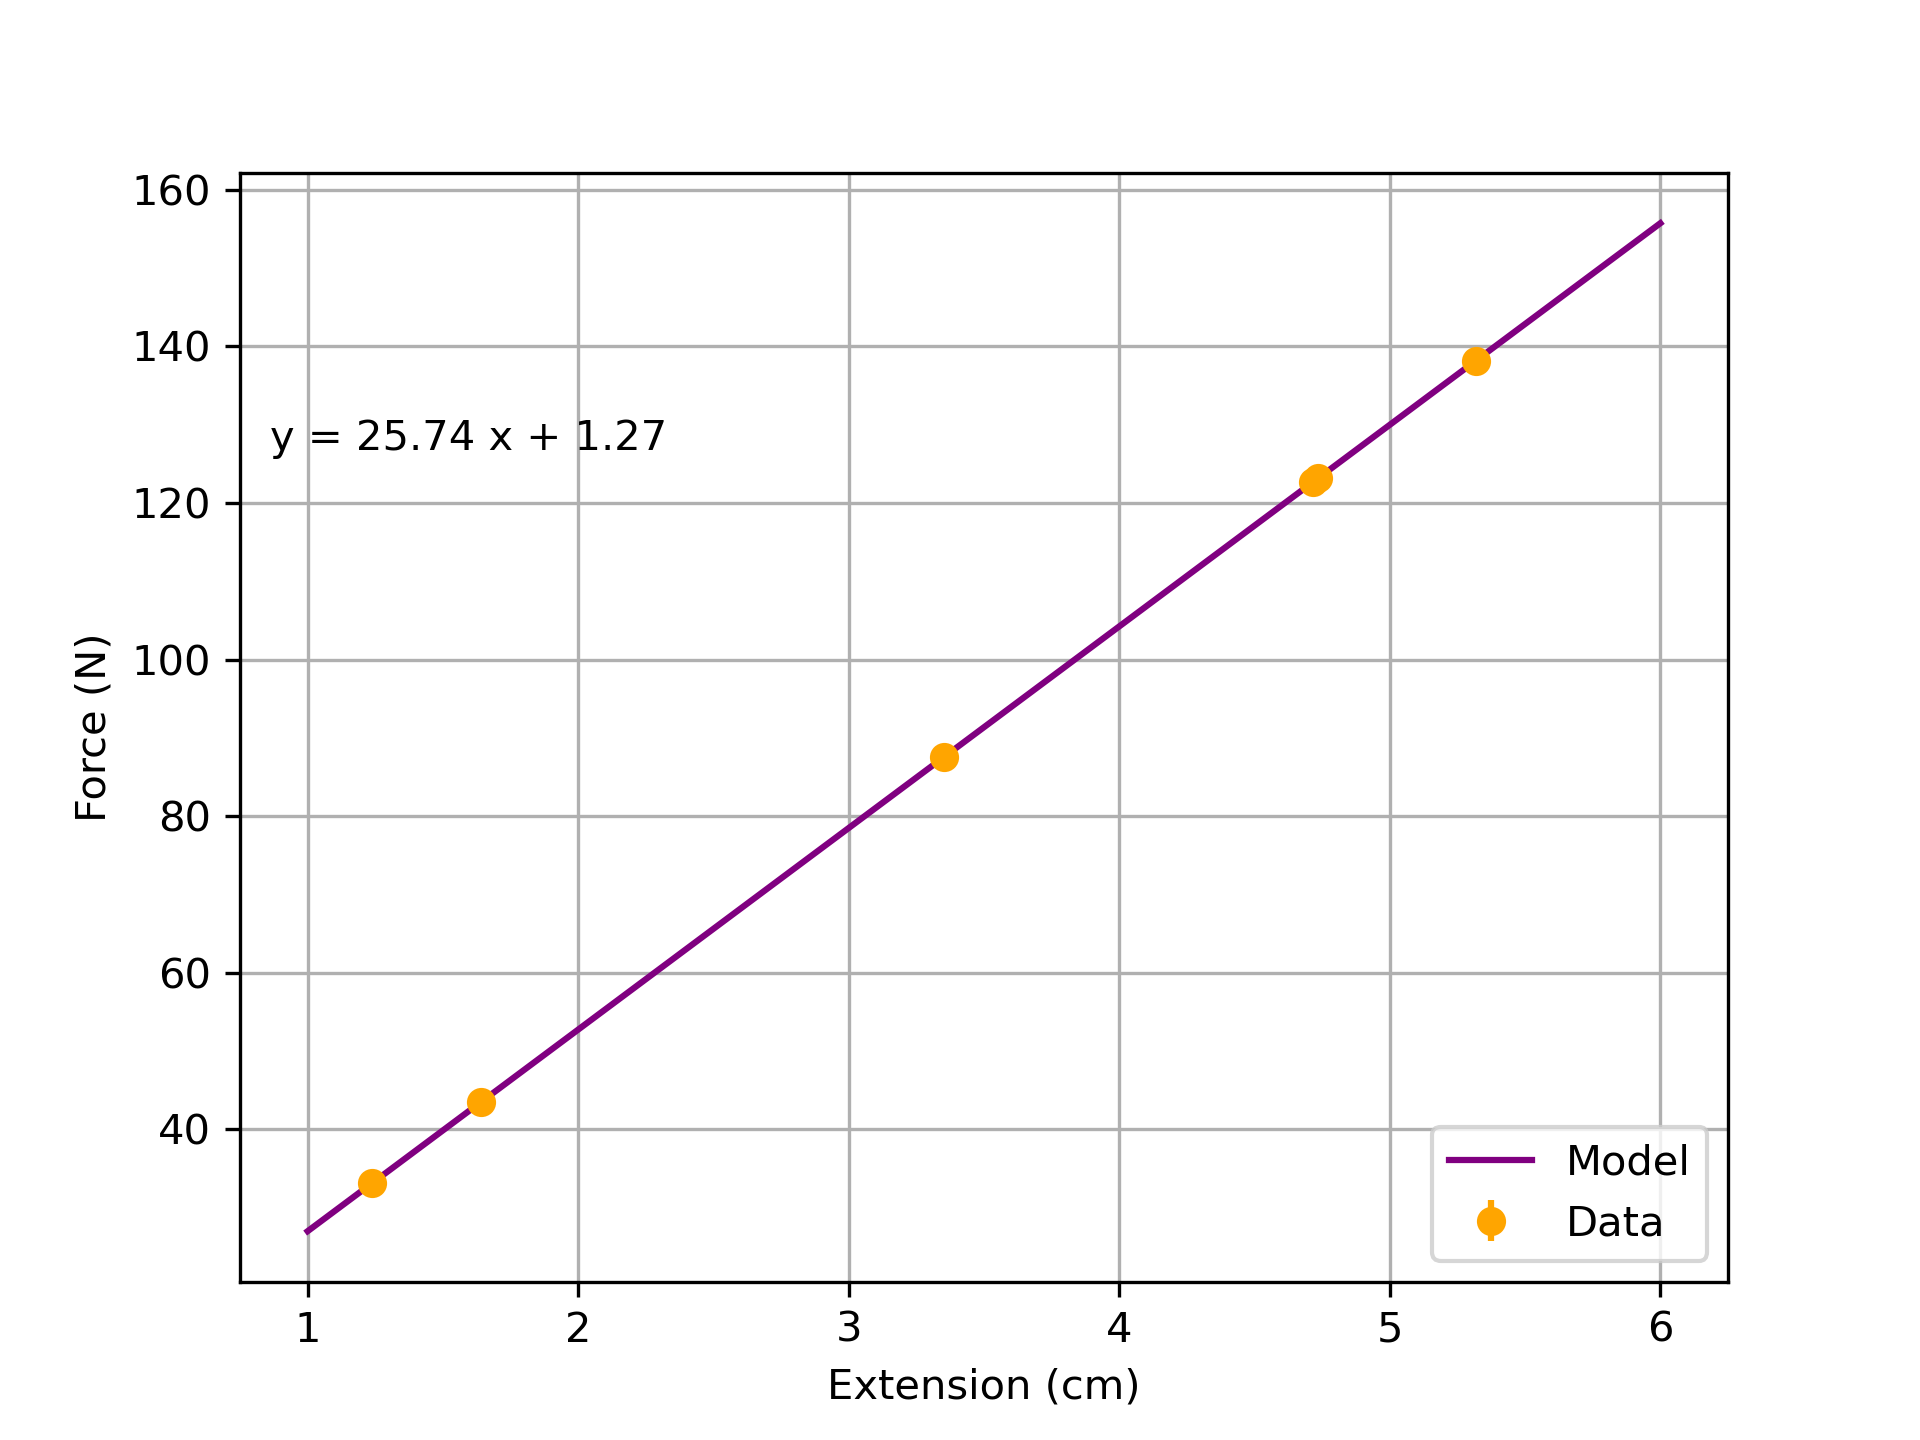

In [23]:
m = student_output.beta[0]
b = student_output.beta[1]

plt.figure()
model = f((m, b), extension)
chiSquared_fit = chiSquared(force, force_err, model)

plt.errorbar(extension + student_output.delta, force + student_output.eps,
             yerr=force_err, marker="o",
             linestyle="None",label="Data",color="orange")
plt.plot(extension, model, linestyle='-',color="purple",
        label="Model")

plt.annotate("y = %.2f x + %.2f" %(m, b), xy=(.02, .75),
            xycoords='axes fraction')

plt.xlabel("Extension (cm)")
plt.ylabel("Force (N)")
plt.grid()
plt.legend(loc='lower right')

So what happens when I give it a very small uncertainty for $x$?

In [24]:
student_model2 = odr.Model(f)
student_data2 = odr.RealData(extension, force, sy=force_err, sx=0.001)
student_odr2 = odr.ODR(student_data2, student_model2, beta0=[0, 0])
student_output2 = student_odr2.run()

In [25]:
student_output2.pprint()

Beta: [21.92614755 14.6185217 ]
Beta Std Error: [ 4.57746821 17.82663906]
Beta Covariance: [[ 0.01431341 -0.05009694]
 [-0.05009694  0.21708584]]
Residual Variance: 1463.8866184905455
Inverse Condition #: 0.09903149062592541
Reason(s) for Halting:
  Sum of squares convergence


In [26]:
print(student_output2.delta)
print(student_output2.eps)

[-0.00029628 -0.00131049  0.00062353  0.00182223  0.00121945 -0.00205846]
[  3.37817291  14.94208272  -7.10936414 -20.77693352 -13.90400276
  23.47027296]


<IPython.core.display.Javascript object>


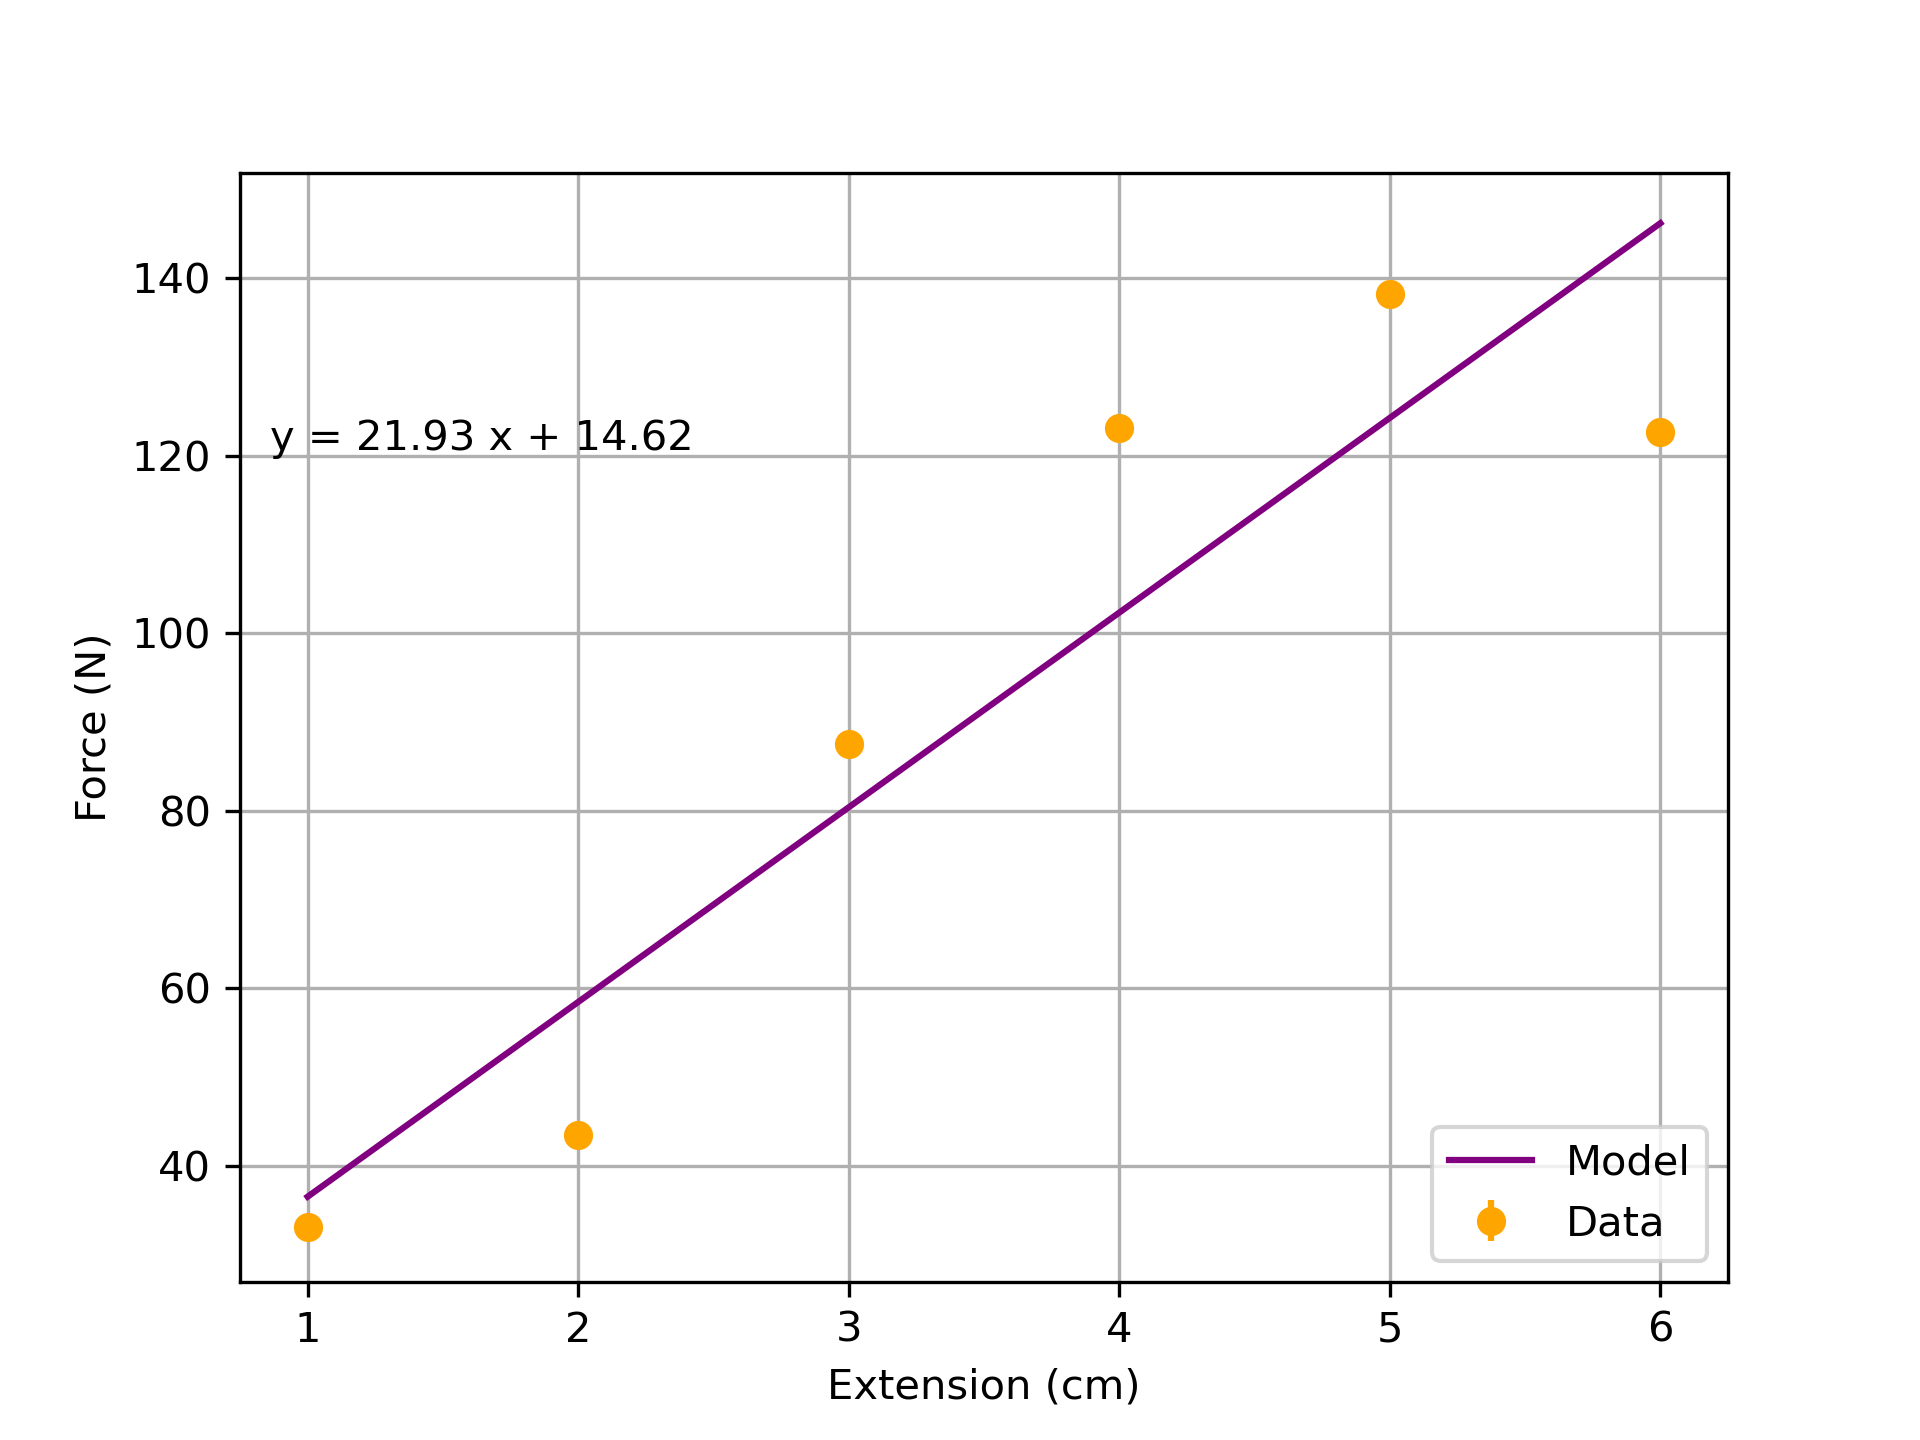

1466.7017072761018


In [27]:
m = student_output2.beta[0]
b = student_output2.beta[1]

plt.figure()
model = f((m, b), extension)
chiSquared_fit = chiSquared(force, force_err, model)

plt.errorbar(extension, force, yerr=force_err, marker="o",
             linestyle="None",label="Data",color="orange")
plt.plot(extension, model, linestyle='-',color="purple",
        label="Model")

plt.annotate("y = %.2f x + %.2f" %(m, b), xy=(.02, .75),
            xycoords='axes fraction')

plt.xlabel("Extension (cm)")
plt.ylabel("Force (N)")
plt.grid()
plt.legend(loc='lower right')

print(chiSquared_fit / (6 - 2))

Ok, so now it's not letting $x$ values change (very small `delta`), and the residual variance makes a lot more sense. 

But notice this did change my slope a lot: 25.74 N/cm to 21.93 N/cm.

So why does ODR let the $x$ values change if I don't specify errors? My guess is there's some default for it. Let's try using `ifixx` in the `ODR` class. 

In [28]:
student_model3 = odr.Model(f)
student_data3 = odr.RealData(extension, force, sy=force_err)
student_odr3 = odr.ODR(student_data3, student_model3, beta0=[0, 0], ifixx=np.zeros(len(extension)))
student_output3 = student_odr3.run()

In [29]:
student_output3.pprint()

Beta: [21.91885714 14.644     ]
Beta Std Error: [ 4.57742925 17.8265299 ]
Beta Covariance: [[ 0.01428571 -0.04999999]
 [-0.04999999  0.21666667]]
Residual Variance: 1466.7007771428575
Inverse Condition #: 0.09903219497816608
Reason(s) for Halting:
  Sum of squares convergence


In [30]:
print(student_output3.delta)
print(student_output3.eps)

[0. 0. 0. 0. 0. 0.]
[  3.40285714  14.98171429  -7.11942857 -20.82057143 -13.94171429
  23.49714286]


And that seemed to do it.